# This is to develope the functions to work with multiple tiles and write output to files
Shadab Alam


In [1]:
using Pkg
#pkg"activate ../src/MockFBA"
#pkg"add FITSIO"

In [2]:
include("../src/MockFBA.jl")
import MockFBA

LoadError: importing MockFBA into Main conflicts with an existing identifier

In [3]:
using Printf
using JLD2
using Plots
using BenchmarkTools
using YAML
using FITSIO
using Dates

In [4]:
using MockFBA

LoadError: importing MockFBA into Main conflicts with an existing identifier

In [4]:
config=YAML.load_file("../config.yaml")


Dict{Any, Any} with 9 entries:
  "RandomSeed"        => 1
  "focal_plane"       => Dict{Any, Any}("focalplane_dir"=>"/Users/shadab/Docume…
  "steps"             => ["pre-process", "assignment", "post-process"]
  "TILES"             => Dict{Any, Any}("PROGRAM"=>"DARK", "tile_file"=>"/Users…
  "sky"               => "SGC"
  "OUTPUT"            => Dict{Any, Any}("JLD2_dir"=>"/Users/shadab/Documents/Pr…
  "target"            => Dict{Any, Any}("QSO"=>Dict{Any, Any}("Num_obs"=>1, "JL…
  "group"             => "SGC"
  "NumFBARealization" => 100

In [175]:



map_TILEID2PASS(config)
#tiles_2pass maps


Loading tiles from: /Users/shadab/Documents/Projects/MockFBA/footprint/Tiles_year1.fits


Dict{Integer, Integer} with 669 entries:
  4805  => 2
  10548 => 6
  2261  => 0
  1175  => 0
  1855  => 0
  2288  => 0
  1546  => 0
  3235  => 1
  1010  => 0
  7805  => 4
  7405  => 4
  10520 => 6
  6371  => 3
  4802  => 2
  4988  => 2
  4814  => 2
  1188  => 0
  7808  => 4
  4135  => 2
  6754  => 3
  8544  => 4
  1722  => 0
  4807  => 2
  4673  => 2
  5376  => 2
  ⋮     => ⋮

In [246]:
"""applly partitions and return indices
nobj::Integer Numbe of objects needs to be divided 
npartition::Integer number of partitions needed
mypart: The partition needs to be selected should be between 0 and npartition-1
"""
function partition_indices(nobj,npartition,mypart)
    @assert ((mypart<npartition) & (mypart>=0)) "Selected partion $(mypart) is not in the range 0-$(npartition-1)"
    #How many should I execute
    nobj_per_part= Int(floor(nobj/npartition))
    
    if(nobj_per_part==0)
        println("Too many partition asked for, setting one object per partition,>$(nobj) partiitons will be empty ")
        nobj_per_part=1
        if(mypart<nobj)
            beg_index=mypart+nobj_per_part
            end_index=minimum([beg_index,nobj])
        else
            beg_index=1
            end_index=0
        end
    else
        #The indices of tiles I will execute
        beg_index=(mypart*nobj_per_part)+1
        end_index=minimum([beg_index+nobj_per_part-1,nobj])
        if(mypart==npartition-1)
            end_index=nobj
        end
    end
    
    return beg_index,end_index
end

"""
Loads all the tiles as per config file and generate a tileid to pass map
"""
function map_TILEID2PASS(config)
    #load all the files load tiles from all the pass
    tiles_dic=MockFBA.load_DESI_tiles(config["TILES"]["tile_file"],config["TILES"]["PROGRAM"],
                  nothing,config["sky"])
    tiles_pass=Dict{Integer,Integer}()
    
    for ii in 1:size(tiles_dic["TILEID"],1)
        tiles_pass[tiles_dic["TILEID"][ii]]=tiles_dic["PASS"][ii]
    end
        
    return tiles_pass
end

"""For each zone and each and given tracer writes the fits file including FBA information
config: input config dictionary loaded from config file
tracer: One of the tracer in the targets categories
group: The overall group we are working with this should be consistent among all the steps
mypart: which partition of the zones needs to be executed
npart_zone: How many partition we want for zones, ech partition we work in parallell cpu
columns: The list of columns tow write apart from FBA related output read from tile files
nbit_pack: How many bits to pack together, the code works for 64 or 32 but FITSIO library can-not write
UInt64 and hence only 32 will work at the moment.
"""
function PostFBA_JLD2FITS(config,tracer,group,mypart_zone,npart_zone,;
        columns=["RA","DEC","FITS_index"],nbit_pack=32)
    #= for the group in config file
    scan alls the zones and write them to fits including the FBA info from tile file
    =#
    
    @assert ((nbit_pack==32) || (nbit_pack==64)) "Invalid bitpacking size $(nbit_pack), must be 32 or 64"

    jldfile=config["target"][tracer]["JLDfile"]
    group=config["group"]
    num_fba=config["NumFBARealization"]
    
    
    #file=jldopen(jldfile,"r")
    #@show keys(file[group]["zone_77"])
    #close(file)
    #return
    #load the zones in group
    jld_order=MockFBA.traverse_group(jldfile,group)
    
    nzone=size(jld_order["zone_order"],1)
    izone_min,izone_max=MockFBA.partition_indices(nzone,npart_zone,mypart_zone)
    
    #load the listing to identify the zones which has tile
    listing=load(jldfile,"$(group)/listing")

    #maximum number of objects among the zones of interest
    max_nobj=maximum(jld_order["nobj"][izone_min:izone_max])
    
    #declare array to store info to be written
    tracer_targets=Dict{String,Array}("RA"=>zeros(Float32,max_nobj),"DEC"=>zeros(Float32,max_nobj))
    for col in columns
        if(col in ["FITS_index","TILEID"])
            tracer_targets[col]=zeros(Int64,max_nobj)
        else
            tracer_targets[col]=zeros(Float32,max_nobj)
        end
    end

    #FBA related quantities
    tracer_targets["FBA_PASS_R1"]=zeros(Int8,max_nobj) .-1
    tracer_targets["FBA_LOCATION_R1"]=zeros(Int16,max_nobj)
    
    #additionally we need to load the group index to match the object in FBA
    tracer_targets["index_group"]=zeros(Int64,max_nobj)
    #To keep a count of how many times and object is assigned for R1, THis is for sanity checks
    tracer_targets["Count_R1"]=zeros(Int32,max_nobj)
    
    #number of bitweights are needed given fba and packing rate
    nbitweight=Int(floor(num_fba/nbit_pack))
    if(nbitweight*nbit_pack<num_fba)
        println("Warning: Want to pack $(num_fba) bits in $(nbit_pack), will use only first $(nbitweight*nbit_pack)")
        println("Warning: Ignoring the last $(num_fba-(nbitweight*nbit_pack)) realizations")
    end
    
    for ii in 1:nbitweight
        if(nbit_pack==32)
            tracer_targets["FBA_BITS$(ii)"]=zeros(UInt32,max_nobj)
        else
            tracer_targets["FBA_BITS$(ii)"]=zeros(UInt64,max_nobj)
        end
    end
    
    #generate and tileif 2d passs maps
    tiles_pass=map_TILEID2PASS(config)
    
    @show izone_min,izone_max, max_nobj
    
    for iz in izone_min:izone_max
        fill!(tracer_targets["FBA_PASS_R1"],-1)
        fill!(tracer_targets["FBA_LOCATION_R1"],-1)
        
        #check the number of tiles in the zone 
        #if it is one with tileid=0 mean none of the tiles in zone and hence skip
        if(listing["TILEID"][iz]==[0])
            println("Warning: No tile in zone $(iz), skipping")
            continue
        end
        
        
        #Number of objects in this zone
        nobj_zone=jld_order["nobj"][iz]
        
        #poiting to the group in the file for this zone
        tg=jld_order["zone_order"][iz]

        zone_imin=jld_order["beg_index"][iz]
        zone_imax=zone_imin+jld_order["nobj"][iz]-1
        zone_nobj=jld_order["nobj"][iz]
        
        
        #indices of objects in the zone
        tracer_targets["index_group"][1:nobj_zone] .= collect(zone_imin:zone_imax)
        
        
        #collect different columns directly available in JLD2 zones file
        for col in columns
            #get the columns based on the need
            #tval=load(jldfile,"$(tg)$(col)")
            tracer_targets[col][1:nobj_zone] .= load(jldfile,"$(tg)$(col)")
            
            #if(col in keys(tracer_targets))
            #    tracer_targets[col]=[tracer_targets[col];tval]
            #else
            #    tracer_targets[col][1:nobj_zone]=tval
            #end
        end
        
        #collect the columns from FBA procedure by reading the tile files
        fill_FBA_results!(config,tiles_pass,tracer,listing["TILEID"][iz],tracer_targets,nobj_zone,
            num_fba,nbitweight,nbit_pack) 
        
        
        
        #columns to write
        col_write=[]
        array_write=[]
        tmp_dic=Dict{String,Array}()
        for col in keys(tracer_targets)
            #if(col in ["index_group","Count_R1"]) #columns to skip
            #    continue
            #end
            #append!(col_write,[col])
            #append!(array_write,view(tracer_targets[col],1:nobj_zone))
            #println(col,nobj_zone,size(tracer_targets[col]))
            tmp_dic[col]=view(tracer_targets[col],1:nobj_zone)
        end
        
        #fits file to write this zone 
        outfits=MockFBA.ZoneFITS_FileName(config,iz,tracer,group)
        FITS(outfits,"w") do fout
            #write(fout,tracer_targets)
            #write(fout,col_write,array_write)
            write(fout,tmp_dic) #Here we write to the fits file
        end
        println(now(UTC)," written: $(nobj_zone)",outfits)
        #break

    end #end of the iz loop
    
    
    return tracer_targets
end
    
    
function fill_FBA_results!(config,tiles_pass,tracer,tile_list,tracer_targets,nobj_zone,
            num_fba,nbitweight,nbit_pack)    
    #index to sort the objects in tile by index field
    zone_isort=sortperm(tracer_targets["index_group"][1:nobj_zone])
    
    #To account for how many times an object is assigned for realization 1
    fill!(tracer_targets["Count_R1"],0)

    for tile_id in tile_list
        if(tile_id==0) #Not an actuall tile used to fill values
            continue
        end
        #FBA jldfile for the tile
        fba_jldfile=MockFBA.TileFBA_FileName(config,tile_id)

        index_pre_tile=load(fba_jldfile,"$(tracer)_index")
        bool_ass=load(fba_jldfile,"$(tracer)_Bool_ass")
        location_ass=load(fba_jldfile,"$(tracer)_location_ass")
        
        #make sure the tile was assigned with consistent num_fba
        @assert num_fba==size(bool_ass,2) "inconsistent num_fba \nfor tile: $(col_tile) in $(fba_jldfile)"

        #find the sorting permutation
        isort_perm=sortperm(index_pre_tile)

        #rearrange with sorted index for this tile
        index_pre_tile=index_pre_tile[isort_perm]
        bool_ass=bool_ass[isort_perm,:]
        location_ass=location_ass[isort_perm,:]
        
        #find the pass for this tile
        #@show tile_id, tiles_pass[tile_id]
        tile_pass=tiles_pass[tile_id]

        #append the info from FBA #follow the logic of sorted indices
        ctile=1
        for ti in 1:size(index_pre_tile,1)
            while(index_pre_tile[ti]>tracer_targets["index_group"][zone_isort[ctile]])
                ctile +=1
                if(ctile>nobj_zone)
                    break
                end
            end

            if(ctile>nobj_zone)
                break
            end

            if(index_pre_tile[ti]==tracer_targets["index_group"][zone_isort[ctile]])
                ind_zone=zone_isort[ctile]
                
                
                #Now fill the needed information for first realization
                if(bool_ass[ti,1]==true)
                    #println(ti,' ',ctile,' ',ind_zone,' ',tile_pass)
                    #track the counts for first realization
                    #println(typeof(ind_zone),typeof(tracer_targets["index_group"]))
                    tracer_targets["Count_R1"][ind_zone] +=1
                    tracer_targets["FBA_PASS_R1"][ind_zone]= tile_pass
                    tracer_targets["FBA_LOCATION_R1"][ind_zone]=location_ass[ti,1]
                end
                #Now fill the FBA_BITS
                PackBITS!(nbitweight,nbit_pack,bool_ass[ti,:],tracer_targets,ind_zone)
            end
        end
        println(tile_id,' ',tile_pass," counts (min,max):",minimum(tracer_targets["Count_R1"]),' ',maximum(tracer_targets["Count_R1"]))
        #break
    
    end
    #Sanity checks
     
    if(maximum(tracer_targets["Count_R1"]) > config["target"][tracer]["Num_obs"])
        nmore=size(findall(tracer_targets["Count_R1"] .> config["target"][tracer]["Num_obs"]),1)
        msg_warn="$(tracer): $(nmore)/$(nobj_zone) objects have more than $(config["target"][tracer]["Num_obs"]) assignment for realization 1"
        println("Warning: $(msg_warn)")
    end
    println("counts (min,max):",minimum(tracer_targets["Count_R1"]),' ',maximum(tracer_targets["Count_R1"]))
    println(unique(tracer_targets["Count_R1"]))
end

"""Converts and array of boolean to UInt64 representation
example: value_out =UInt64(0)
bool_in=ones(Bool,32)
bool_in[1]=false #[false,false,false]#tar[1,1:4]
#@show value_out
value_out=Bool2UInt(bool_in,value_out)
@show bool_in
@show value_out,typeof(value_out)
@show bitstring(value_out)
"""
function Bool2UInt(bool_in,value_out::UInt64)
    #@show value_out
    value_out=UInt64(0)
    for ii in 1:size(bool_in,1)
        if(bool_in[ii])
            value_out += UInt64(2)^(ii-1)
            #println(ii,' ',value_out,' ',typeof(value_out))
        end
    end
    return value_out
end

"""Converts and array of boolean to UInt32 representation
example:
value_out =UInt32(0)
bool_in=ones(Bool,32)
bool_in[1]=false #[false,false,false]#tar[1,1:4]
#@show value_out
value_out=Bool2UInt(bool_in,value_out)
@show bool_in
@show value_out,typeof(value_out)
@show bitstring(value_out)
"""
function Bool2UInt(bool_in,value_out::UInt32)
    value_out=UInt32(0)
    #@show value_out
    for ii in 1:size(bool_in,1)
        if(bool_in[ii])
            value_out += UInt32(2)^(ii-1)
            #println(ii,' ',value_out,' ',typeof(value_out))
        end
    end
    return value_out
end

"""
Transfers the bollean array to array of UInt32 or UInt64
nbitweight: Number of bitweights columns
nbit_pack: 32 or 64 the unitsize of packing
bool_in: Input boolean array of atleast nbitweight*nbit_pack size
pack_out: output array of size nbitweight and type UInt32 or UInt64 based on nbit_pack
"""
function PackBITS!(nbitweight,nbit_pack,bool_in,tracer_targets,ind_zone)
    for ii in 1:nbitweight
        imin=((ii-1)*nbit_pack)+1
        imax=imin+nbit_pack-1
        tracer_targets["FBA_BITS$(ii)"][ind_zone]=Bool2UInt(bool_in[imin:imax],
            tracer_targets["FBA_BITS$(ii)"][ind_zone])
        #println(ii,' ',bool_in[imin:imax])
        #println(bitstring(pack_out[ii]))
    end
end

tracer="LRG"
group="SGC"
mypart_zone=0
npart_zone=3
#tdic=PostFBA_JLD2FITS(config,tracer;columns=["RA","DEC","BITWEIGHT","POS_LOCATION"])
PostFBA_JLD2FITS(config,tracer,group,mypart_zone,npart_zone,;columns=["RA","DEC","FITS_index",
        "TILEID_PASS0","TILEID_PASS1","TILEID_PASS2","TILEID_PASS3","TILEID_PASS4","TILEID_PASS5",
        "TILEID_PASS6"])

#@show partition_indices(11,5,4)

#=
nbit_pack=32
nbitweight=3
bool_in=tar[2,:]
pack_out=zeros(UInt32,nbitweight)
PackBITS!(nbitweight,nbit_pack,bool_in,pack_out)

for ii in 1:size(pack_out,1)
    println("out ",ii,' ',bitstring(pack_out[ii]))
end
=#

print("Finished")

Loading tiles from: /Users/shadab/Documents/Projects/MockFBA/footprint/Tiles_year1.fits
(izone_min, izone_max, max_nobj) = (1, 8, 318202)
7408 4 counts (min,max):0 1
counts (min,max):0 1
Int32[0, 1]
2022-01-18T14:23:48.261 written: 107320/Users/shadab/Documents/Projects/MockFBA/mocks/FITS_FBA/FBA_ph000/tmp/SGC_LRG_zone_1.fits.gz
2049 0 counts (min,max):0 1
1006 0 counts (min,max):0 1
2065 0 counts (min,max):0 1
2047 0 counts (min,max):0 1
2048 0 counts (min,max):0 1
2042 0 counts (min,max):0 1
2051 0 counts (min,max):0 1
2045 0 counts (min,max):0 1
2053 0 counts (min,max):0 1
2052 0 counts (min,max):0 1
2061 0 counts (min,max):0 1
2062 0 counts (min,max):0 1
1155 0 counts (min,max):0 1
1188 0 counts (min,max):0 1
1147 0 counts (min,max):0 1
1175 0 counts (min,max):0 1
1176 0 counts (min,max):0 1
1165 0 counts (min,max):0 1
1145 0 counts (min,max):0 1
1146 0 counts (min,max):0 1
1154 0 counts (min,max):0 1
1546 0 counts (min,max):0 1
3622 1 counts (min,max):0 2
2750 1 counts (min,max):0

In [259]:
tdic=Dict("tarr"=> rand(10))
@show tdic
isort_p=sortperm(tdic["tarr"])
@show isort_p
@show "bef: ",repr(UInt64(pointer_from_objref(tdic["tarr"])))
tdic["tarr"] .= tdic["tarr"][isort_p]
@show "aft: ",repr(UInt64(pointer_from_objref(tdic["tarr"])))
@show tdic["tarr"]
println(tarr isa Matrix,' ',tarr isa Array)

tdic = Dict("tarr" => [0.364997451177828, 0.17813350344007983, 0.6352526708869001, 0.7356833170513722, 0.8191066276970774, 0.5647877182438021, 0.37029384063322757, 0.5740863739465919, 0.8230187009092134, 0.9273636875789549])
isort_p = [2, 1, 7, 6, 8, 3, 4, 5, 9, 10]
("bef: ", repr(UInt64(pointer_from_objref(tdic["tarr"])))) = ("bef: ", "0x000000018f00c400")
("aft: ", repr(UInt64(pointer_from_objref(tdic["tarr"])))) = ("aft: ", "0x000000018f00c400")
tdic["tarr"] = [0.17813350344007983, 0.364997451177828, 0.37029384063322757, 0.5647877182438021, 0.5740863739465919, 0.6352526708869001, 0.7356833170513722, 0.8191066276970774, 0.8230187009092134, 0.9273636875789549]
false true


# To process a pass

In [204]:
import Pkg; Pkg.add("DataStructures")
using DataStructures

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Documents/Projects/MockFBA/Project.toml`
  [864edb3b] + DataStructures v0.18.11
  No Changes to `~/Documents/Projects/MockFBA/Manifest.toml`


In [162]:
outfits="test.fits"
tdic=Dict{String,Array}()
tdic["RA"]=zeros(Float32,10)
tdic["FBA_BITS"]=zeros(UInt32,10,5)
FITS(outfits,"w") do fout
    write(fout,tdic)
end

In [10]:
jldfile=config["target"][tracer]["JLDfile"]
group=config["group"]
    
#load the zones in group
jld_order=MockFBA.traverse_group(jldfile,group)

Dict{Any, Any} with 3 entries:
  "beg_index"  => Any[1, 44668, 103732, 161060, 189933, 200647, 232136, 267555,…
  "nobj"       => Any[44667, 59064, 57328, 28873, 10714, 31489, 35419, 131670, …
  "zone_order" => Any["SGC/zone_77/", "SGC/zone_78/", "SGC/zone_79/", "SGC/zone…

In [26]:
listing=load(jldfile,"$(group)/listing")
for iz in keys(listing["TILEID"])
    if(listing["TILEID"][iz]==[0])
        println("iz= ",iz)
    end
    println(iz, ' ',length(listing["TILEID"][iz]),' ',jld_order["nobj"][iz])
end

iz= 5
5 1 10714
iz= 16
16 1 122983
20 9 124128
12 65 71602
24 3 13911
8 150 131670
iz= 17
17 1 10146
1 2 44667
19 12 103687
22 2 15211
23 3 3143
iz= 6
6 1 31489
11 43 50567
9 146 131747
14 149 131568
iz= 3
3 1 57328
iz= 7
7 1 35419
iz= 4
4 1 28873
13 132 132536
15 5 124203
iz= 2
2 1 59064
10 64 85994
18 3 11335
iz= 21
21 1 13932


In [6]:
tile_index_arr=[39,40,41]
MockFBA.Run_Many_Tile(config,tile_index_arr,tiles_dic;tile_date="2019-09-16T00:00:00",
    plate_scale=nothing,fp_dic=nothing,exc_dic=nothing,verbose=2)

2022-01-13T16:44:25.737 TILEID:1700 full:12.701 sec(Prepare:0.138 sec,Assignment:9.613 sec,Output:2.95 sec,)
2022-01-13T16:44:30.549 TILEID:1701 full:4.776 sec(Prepare:0.061 sec,Assignment:4.591 sec,Output:0.124 sec,)
2022-01-13T16:44:35.220 TILEID:1706 full:4.671 sec(Prepare:0.066 sec,Assignment:4.434 sec,Output:0.171 sec,)


In [38]:
append!(zeros(Bool,0,1),ones(Bool,3,1))

LoadError: MethodError: no method matching append!(::Matrix{Bool}, ::Matrix{Bool})
[0mClosest candidates are:
[0m  append!([91m::SentinelArrays.ChainedVector{T, A} where A<:AbstractVector{T}[39m, ::Any) where T at ~/.julia/packages/SentinelArrays/PnQnF/src/chainedvector.jl:608
[0m  append!([91m::PooledArrays.PooledVector[39m, ::AbstractArray) at ~/.julia/packages/PooledArrays/DuIZ1/src/PooledArrays.jl:607
[0m  append!([91m::DataInterpolations.LinearInterpolation{U, T}[39m, ::U, [91m::T[39m) where {U, T} at ~/.julia/packages/DataInterpolations/nPkB0/src/online.jl:21
[0m  ...

In [17]:
targets_dic,fp_dic,exc_dic=Prepare_tile(config,tile_index,tiles_dic;tile_date="2019-09-16T00:00:00",
        plate_scale=nothing,fp_dic=nothing,exc_dic=nothing)

LoadError: UndefVarError: Prepare_tile not defined

In [13]:
?MockFBA.Prepare_tile

No documentation found.

Binding `Main.MockFBA.Prepare_tile` does not exist.


In [7]:
?MockFBA.Assign_Tile

Runs the assignment for a given tile num*fba: number of fba realization to generate max*vertices maximum number of vertices any of the positioner polygon can have max*ngb*pos: maximum number of negibohuring positioner any positioner can have


In [8]:
for ii in 1:2:6
    println(ii)
end

1
3
5


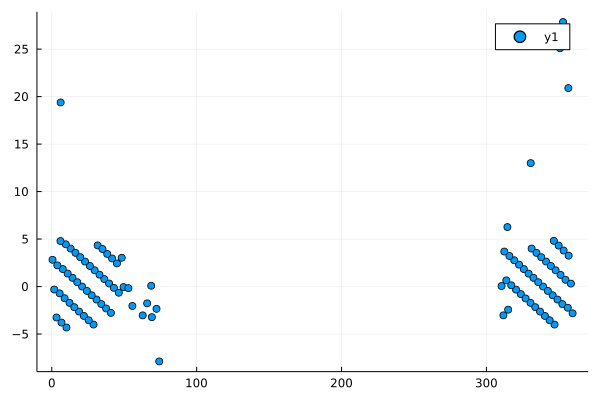

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423
┌ Warning: Module FFMPEG_jll with build ID 11994865188825715 is missing from the cache.
│ This may mean FFMPEG_jll [b22a6f82-2f65-5046-a5b2-351ab43fb4e5] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9].
└ @ Base loading.jl:1124


In [12]:
plot(tiles_dic["RA"],tiles_dic["DEC"],seriestype=:scatter)

In [18]:
using CodecLz4

In [13]:
using JLD2
jldopen("example.jld2", "w") do f
    # This can be efficiently compressed  → use compression
    write(f, "compressed_array", zeros(10000); compress=true)

    # Don't compress this 
    write(f, "large_array", rand(10000))
end

In [22]:
jldopen("example2.jld2", "w",compress=LZ4FrameCompressor()) do f
    # This can be efficiently compressed  → use compression
    write(f, "compressed_array", zeros(10000); compress=true)

    # Don't compress this 
    write(f, "large_array", ["a1","b1","c1","d1"], compress=true)
end

In [27]:
file=jldopen("/Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/FBA_ph000/TILEID_9674.jld2","r")

JLDFile /Users/shadab/Documents/Projects/MockFBA/mocks/JLD2_data/FBA_ph000/TILEID_9674.jld2 (read-only)
 ├─🔢 ELG_Bool_ass
 ├─🔢 ELG_location_ass
 ├─🔢 ELG_index
 ├─🔢 LRG_Bool_ass
 ├─🔢 LRG_location_ass
 ├─🔢 LRG_index
 ├─🔢 QSO_Bool_ass
 ├─🔢 QSO_location_ass
 └─🔢 QSO_index

In [33]:
tar=file["QSO_Bool_ass"]

2034×100 Matrix{Bool}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  0  1  1
 1  0  1  1  1  1  1  1  0  1  1  0  1     1  1  1  1  1  0  1  1  0  1  0  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     0  0  1  1  0  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  1  0  0  1  1  0     0  1  0  0  0  1  0  0  0  1  0  1
 1  0  1  0  0  1  0  0  0  1  0  0  0     0  0  1  0  0  0  1  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  1  1  0  0  0
 1  0  0  0  0  0  0  0  0  1  1  0  0     0  0  0  0  1  0  1  1  0  1  0  0
 1  0  0  0  1  0  1  0  0  1  1  1  1     1  1  1  1  1  0  1  1  0  1  1  1
 0  0  0  1  1  0  1  1  0  0  0  1  0     0  0  0  0  0  0  0  1  0  0  1  0
 1  0  1  0  1  1  1  0  0  1  1  1  1     1  1  1  0  0  1  1  0  0  0  1  1
 0  0  1  0  1  1  1  0  1  0  1  0  0  …  1  0  0  0  0  1  0  0  0  0  1  0
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  0  1  1  1  1  1  1  1  1  1  1   

bool_in = Bool[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
(value_out, typeof(value_out), value_out == 15) = (0xfffffffe, UInt32, false)
bitstring(value_out) = "11111111111111111111111111111110"
  0.000018 seconds (1 allocation: 16 bytes)
elapsed time (ns): 17656
bytes allocated:   16
pool allocs:       1


0xfffffffe

In [135]:
@btime  Bool2UInt(bool_in,value_out)

  149.207 ns (1 allocation: 16 bytes)


0xfffffffe

In [91]:
typeof(UInt64(2)^63)

UInt64

In [262]:
"$(now(UTC))"

"2022-01-18T16:08:46.151"

In [263]:
sum([1,2])

3

In [289]:
outfits="test-tiles.fits"
tdic=Dict{String,Array}()
tdic["RA"]=[340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,340.0,
            180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0]
tdic["DEC"]=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
            10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0]
tdic["PROGRAM"]=["DARK","DARK","DARK","DARK","DARK","DARK","DARK","DARK","DARK","DARK",
"DARK","DARK","DARK","DARK","DARK","DARK","DARK","DARK","DARK","DARK"]
tdic["PASS"]=[0,1,2,3,4,5,6,7,8,9,
            0,1,2,3,4,5,6,7,8,9]
tdic["TILEID"]=[0,1,2,3,4,5,6,7,8,9,
                10,11,12,13,14,15,16,17,18,19]

FITS(outfits,"w") do fout
    #write(fout,tracer_targets)
    #write(fout,col_write,array_write)
    write(fout,tdic) #Here we write to the fits file
end
println(now(UTC)," written:",outfits)

2022-01-19T15:52:12.942 written:test-tiles.fits


In [269]:
function fname_tile(tileid)
    return "/Users/shadab/Documents/Projects/MockFBA/mocks_v2/JLD2_data/FBA_ph000/TILEID_$(tileid).jld2"
end

f1=jldopen(fname_tile(1),"r")
f11=jldopen(fname_tile(11),"r")

JLDFile /Users/shadab/Documents/Projects/MockFBA/mocks_v2/JLD2_data/FBA_ph000/TILEID_11.jld2 (read-only)
 ├─🔢 ELG_Bool_ass
 ├─🔢 ELG_location_ass
 ├─🔢 ELG_index
 ├─🔢 LRG_Bool_ass
 ├─🔢 LRG_location_ass
 ├─🔢 LRG_index
 ├─🔢 QSO_Bool_ass
 ├─🔢 QSO_location_ass
 └─🔢 QSO_index

In [272]:
ind1=sort(f1["QSO_index"][f1["QSO_Bool_ass"][:,1]])
ind11=sort(f11["QSO_index"][f11["QSO_Bool_ass"][:,1]])

1548-element Vector{Any}:
  740501
  740515
  740524
  740532
  740539
  740801
  740830
  740831
  740834
  741914
  741922
  741933
  741947
       ⋮
 1001385
 1001435
 1001449
 1001457
 1001483
 1001692
 1001710
 1001735
 1003107
 1003169
 1003170
 1003173

In [273]:
size(ind1),size(ind11)

((1756,), (1548,))

In [276]:
ind1[1:5],ind11[1:5]

(Any[740501, 740515, 740524, 740525, 740532], Any[740501, 740515, 740524, 740532, 740539])

In [286]:
xx=indexin([1,2],[0,1,2])

2-element Vector{Union{Nothing, Int64}}:
 2
 3

In [285]:
xx

1-element Vector{Union{Nothing, Int64}}:
 1

In [290]:
sqrt(59157241)

7691.374454543219